In [1]:
import os
import glob
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [2]:
train_dir = '../input/chest-xray-covid19-pneumonia/Data/train/*'
test_dir = '../input/chest-xray-covid19-pneumonia/Data/test/*'
train2_covid_dir = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID'

In [3]:
SIZE = 128
BATCH_SIZE = 64
TARGET_SIZE = (SIZE,SIZE)
EPOCH_NUM = 200

In [4]:
categories_dict = {
  0: "PNEUMONIA",
  1: "NORMAL",
  2: "COVID19"
}

(299, 299, 3)

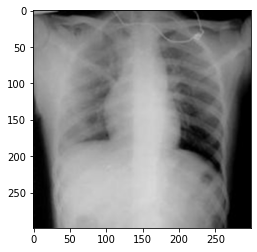

In [5]:
img=cv2.imread('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/COVID-1013.png')
plt.imshow(img)
img.shape

## Extracting subbands using DWT + Merging subbands in one image with shape(128,128,4)

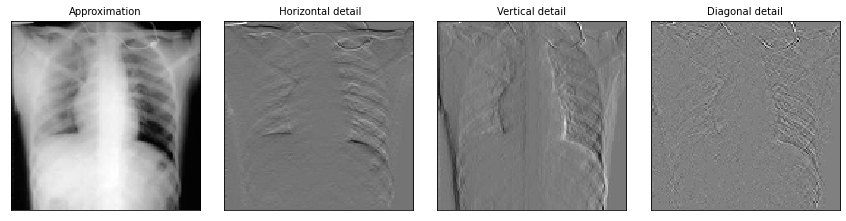

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pywt
import pywt.data


# Load image
original = cv2.resize(img,(256,256)) 
original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
      'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
  ax = fig.add_subplot(1, 4, i + 1)
  ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
  ax.set_title(titles[i], fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

fig.tight_layout()
plt.show()

In [7]:
## Merging 
merged = cv2.merge([LL, LH, HL, HH])
print(merged.shape)

(130, 130, 4)


## Loading Train and Test Data

In [8]:
train_images = []
train_labels = [] 
label = 0

#Importing the first training dataset

for directory_path in glob.glob(train_dir):
    assert categories_dict[label] == os.path.normpath(directory_path).split(os.path.sep)[-1]
    print(categories_dict[label])
    counter = 1
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        if(counter%200==0): print(counter,"images loaded")
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, TARGET_SIZE)
        coeffs2 = pywt.dwt2(img, 'bior1.3')
        LL, (LH, HL, HH) = coeffs2
        for i in [LL,LH,HL,HH]:
            i=cv2.resize(i,TARGET_SIZE)
        img = cv2.merge([LL, LH, HL, HH])
        img=cv2.resize(img,TARGET_SIZE)
        train_images.append(img)
        train_labels.append(label)
        counter+=1
        if(counter%1500==0): break
    
    print(counter,"images loaded")
    label +=1
    
#Importing the additional training dataset

print("additional",categories_dict[2],"data")    
addit_counter = 1
for img_path in glob.glob(os.path.join(train2_covid_dir, "*.png")):
    if(addit_counter%200==0): print(addit_counter,"images loaded")
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, TARGET_SIZE)
    coeffs2 = pywt.dwt2(img, 'bior1.3')
    LL, (LH, HL, HH) = coeffs2
    for i in [LL,LH,HL,HH]:
            i=cv2.resize(i,TARGET_SIZE)
    img = cv2.merge([LL, LH, HL, HH])
    img=cv2.resize(img,TARGET_SIZE)
    train_images.append(img)
    train_labels.append(2)
    addit_counter+=1
    if(addit_counter%1000==0): break
print(addit_counter,"images loaded")

x_train = np.array(train_images)
y_train = to_categorical(train_labels, 3)

PNEUMONIA
200 images loaded
400 images loaded
600 images loaded
800 images loaded
1000 images loaded
1200 images loaded
1400 images loaded
1500 images loaded
NORMAL
200 images loaded
400 images loaded
600 images loaded
800 images loaded
1000 images loaded
1200 images loaded
1267 images loaded
COVID19
200 images loaded
400 images loaded
461 images loaded
additional COVID19 data
200 images loaded
400 images loaded
600 images loaded
800 images loaded
1000 images loaded


In [9]:
x_train[200].shape

(128, 128, 4)

In [10]:
test_images = []
test_labels = []
label = 0

#importing the testing dataset

for directory_path in glob.glob(test_dir):
    assert categories_dict[label] == os.path.normpath(directory_path).split(os.path.sep)[-1]
    print(categories_dict[label])
    counter = 1
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        if(counter%100==0): print(counter, "images loaded")
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, TARGET_SIZE)
        coeffs2 = pywt.dwt2(img, 'bior1.3')
        LL, (LH, HL, HH) = coeffs2
        for i in [LL,LH,HL,HH]:
            i=cv2.resize(i,TARGET_SIZE)
        img = cv2.merge([LL, LH, HL, HH])
        img=cv2.resize(img,TARGET_SIZE)
        test_images.append(img)
        test_labels.append(label)
        counter+=1
    
    print(counter,"images loaded")
    label +=1

test_images = np.array(test_images)
test_labels = to_categorical(test_labels, 3)

PNEUMONIA
100 images loaded
200 images loaded
300 images loaded
400 images loaded
500 images loaded
600 images loaded
700 images loaded
800 images loaded
856 images loaded
NORMAL
100 images loaded
200 images loaded
300 images loaded
318 images loaded
COVID19
100 images loaded
117 images loaded


In [11]:
test_images[0].shape

(128, 128, 4)

### Splitting data into train and validation dataset

In [12]:
train_test_split(train_images, train_labels)
train_images, val_images, train_labels, val_labels = train_test_split(x_train, 
                                                                      y_train, 
                                                                      test_size=0.15, 
                                                                      random_state=69)

In [13]:
print("train:",train_images.shape[0],", test:",test_images.shape[0],", val:",val_images.shape[0])

train: 3590 , test: 1288 , val: 634


## Feature Extraction from subbands using GLCM

In [14]:
from skimage import util, exposure, data
def feature_glcm(image):
    glcm_dataset = pd.DataFrame()
    [LL,LH,HL,HH]=cv2.split(image)
    df = pd.DataFrame()    
    for n ,img in enumerate([LL,LH,HL,HH]):
            img = exposure.rescale_intensity(img, out_range=(0, 1))
            bin_width = 32
            im = util.img_as_ubyte(img)
            img = im//bin_width
            GLCM = greycomatrix(img, [1], [0])       
            GLCM_Energy = greycoprops(GLCM, 'energy')[0]
            df['Energy__subband'+str(n)] = GLCM_Energy
            GLCM_corr = greycoprops(GLCM, 'correlation')[0]
            df['Corr__subband'+str(n)] = GLCM_corr       
            GLCM_diss = greycoprops(GLCM, 'dissimilarity')[0]
            df['Diss_sim__subband'+str(n)] = GLCM_diss       
            GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
            df['Homogen__subband'+str(n)] = GLCM_hom       
            GLCM_contr = greycoprops(GLCM, 'contrast')[0]
            df['Contrast__subband'+str(n)] = GLCM_contr
            GLCM_ASM = greycoprops(GLCM, 'ASM')[0]
            df['ASM__subband'+str(n)] = GLCM_ASM

    glcm_dataset = glcm_dataset.append(df)
    return glcm_dataset

In [15]:
feature_glcm(merged)

,Energy__subband0,Corr__subband0,Diss_sim__subband0,Homogen__subband0,Contrast__subband0,ASM__subband0,Energy__subband1,Corr__subband1,Diss_sim__subband1,Homogen__subband1,...,Diss_sim__subband2,Homogen__subband2,Contrast__subband2,ASM__subband2,Energy__subband3,Corr__subband3,Diss_sim__subband3,Homogen__subband3,Contrast__subband3,ASM__subband3
0,0.339341,0.982179,0.157901,0.92223,0.169708,0.115152,0.903003,0.673699,0.060883,0.969845,...,0.236196,0.889596,0.32421,0.484772,0.567029,0.024502,0.429994,0.791114,0.498927,0.321522


In [16]:
def feature_extractor(images):
    image_dataset = pd.DataFrame()
    for image in images: 
        image_dataset = image_dataset.append(feature_glcm(image))
        
    return image_dataset

In [17]:
train_df= feature_extractor(train_images)

In [18]:
train_df

,Energy__subband0,Corr__subband0,Diss_sim__subband0,Homogen__subband0,Contrast__subband0,ASM__subband0,Energy__subband1,Corr__subband1,Diss_sim__subband1,Homogen__subband1,...,Diss_sim__subband2,Homogen__subband2,Contrast__subband2,ASM__subband2,Energy__subband3,Corr__subband3,Diss_sim__subband3,Homogen__subband3,Contrast__subband3,ASM__subband3
0,0.305223,0.970420,0.221149,0.890262,0.229515,0.093161,0.671352,0.696927,0.153851,0.923234,...,0.100086,0.950665,0.107714,0.735921,0.920597,0.416357,0.061208,0.969872,0.066622,0.847498
0,0.345336,0.972373,0.183501,0.908704,0.188054,0.119257,0.821379,0.640195,0.100886,0.949791,...,0.037279,0.981707,0.041093,0.899937,0.955325,0.429052,0.034387,0.983086,0.037463,0.912647
0,0.351726,0.981854,0.203002,0.899914,0.217151,0.123711,0.889353,0.628057,0.061639,0.969414,...,0.191868,0.904767,0.198880,0.351738,0.830622,0.514352,0.110298,0.945073,0.112512,0.689934
0,0.352222,0.970991,0.149852,0.925468,0.153789,0.124060,0.904862,0.708479,0.049766,0.975437,...,0.095472,0.953684,0.110113,0.744087,0.991699,0.622450,0.007382,0.996575,0.010212,0.983467
0,0.329630,0.968426,0.206877,0.897558,0.216843,0.108656,0.758142,0.659676,0.118910,0.940631,...,0.132628,0.934615,0.142347,0.594621,0.792941,0.464760,0.145423,0.927967,0.152559,0.628755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.383499,0.975457,0.158157,0.922865,0.177596,0.147071,0.597264,0.692440,0.168799,0.915662,...,0.084892,0.958501,0.094365,0.773476,0.877551,0.483827,0.097872,0.952575,0.113497,0.770096
0,0.330955,0.976684,0.209523,0.895842,0.215551,0.109531,0.715163,0.714097,0.176919,0.912451,...,0.255598,0.874871,0.282296,0.316730,0.668797,0.515248,0.225824,0.888244,0.237389,0.447289
0,0.329698,0.974016,0.204048,0.898542,0.209707,0.108701,0.850832,0.619283,0.085076,0.957597,...,0.208846,0.897205,0.225209,0.401795,0.833047,0.502880,0.108821,0.945966,0.112758,0.693967
0,0.312485,0.974515,0.208723,0.896697,0.219304,0.097647,0.820881,0.704449,0.094611,0.952830,...,0.179134,0.911143,0.187254,0.358857,0.977305,0.385743,0.019254,0.990659,0.022207,0.955126


In [19]:
test_df = feature_extractor(test_images)

In [20]:
test_df

,Energy__subband0,Corr__subband0,Diss_sim__subband0,Homogen__subband0,Contrast__subband0,ASM__subband0,Energy__subband1,Corr__subband1,Diss_sim__subband1,Homogen__subband1,...,Diss_sim__subband2,Homogen__subband2,Contrast__subband2,ASM__subband2,Energy__subband3,Corr__subband3,Diss_sim__subband3,Homogen__subband3,Contrast__subband3,ASM__subband3
0,0.295504,0.970590,0.237697,0.882862,0.254798,0.087322,0.666638,0.679397,0.150160,0.925141,...,0.125369,0.940114,0.154158,0.702784,0.929732,0.482784,0.050750,0.974899,0.053580,0.864402
0,0.372642,0.982110,0.177534,0.911922,0.184424,0.138862,0.867869,0.699210,0.070559,0.964979,...,0.181841,0.911128,0.202756,0.508467,0.784935,0.534251,0.148868,0.926390,0.157111,0.616122
0,0.328417,0.973096,0.212045,0.894667,0.218935,0.107858,0.936906,0.551319,0.044968,0.978441,...,0.103162,0.949272,0.111774,0.744641,0.955263,0.448149,0.037279,0.982053,0.044291,0.912527
0,0.395432,0.981668,0.156312,0.922029,0.158157,0.156366,0.853997,0.663899,0.079417,0.960575,...,0.083415,0.959242,0.093258,0.768723,0.978688,0.432695,0.020362,0.990457,0.027005,0.957831
0,0.344925,0.980858,0.177165,0.911860,0.181594,0.118973,0.953049,0.690459,0.027005,0.986559,...,0.126845,0.936688,0.127953,0.520725,0.990722,0.564005,0.007751,0.996248,0.008981,0.981530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.353265,0.980259,0.133858,0.933083,0.133981,0.124796,0.671415,0.717790,0.169845,0.915570,...,0.150406,0.925375,0.156188,0.491619,0.680519,0.493536,0.196235,0.902484,0.202510,0.463106
0,0.363570,0.969567,0.168369,0.915951,0.169722,0.132183,0.615351,0.694360,0.188546,0.905899,...,0.077940,0.961411,0.081754,0.798887,0.864972,0.456880,0.105623,0.947918,0.113004,0.748176
0,0.358661,0.969017,0.179749,0.910938,0.187869,0.128638,0.736167,0.699062,0.138410,0.931176,...,0.161971,0.919642,0.168246,0.582453,0.821108,0.435612,0.137795,0.931983,0.146777,0.674218
0,0.330447,0.969519,0.216658,0.892224,0.222195,0.109195,0.579748,0.795803,0.181287,0.909713,...,0.264210,0.870417,0.289432,0.330406,0.588602,0.549186,0.268639,0.867841,0.290416,0.346452


In [21]:
val_df = feature_extractor(val_images)

In [22]:
val_df

,Energy__subband0,Corr__subband0,Diss_sim__subband0,Homogen__subband0,Contrast__subband0,ASM__subband0,Energy__subband1,Corr__subband1,Diss_sim__subband1,Homogen__subband1,...,Diss_sim__subband2,Homogen__subband2,Contrast__subband2,ASM__subband2,Energy__subband3,Corr__subband3,Diss_sim__subband3,Homogen__subband3,Contrast__subband3,ASM__subband3
0,0.340465,0.979344,0.170091,0.915139,0.171937,0.115916,0.942274,0.601884,0.037217,0.981551,...,0.064530,0.968399,0.071174,0.816083,0.992929,0.570253,0.006951,0.996783,0.009535,0.985908
0,0.308111,0.976277,0.208661,0.896125,0.213214,0.094932,0.743489,0.680181,0.120263,0.940237,...,0.140871,0.931389,0.159203,0.655423,0.987779,0.504715,0.010519,0.994863,0.011750,0.975708
0,0.323853,0.973207,0.216289,0.892532,0.223056,0.104881,0.600345,0.667912,0.172429,0.913921,...,0.149852,0.925677,0.155881,0.554192,0.852849,0.460382,0.102116,0.949246,0.105438,0.727351
0,0.377210,0.979498,0.127645,0.936387,0.129737,0.142287,0.857334,0.793746,0.068406,0.966043,...,0.128322,0.936855,0.138656,0.662955,0.690547,0.505953,0.209830,0.896667,0.226193,0.476855
0,0.295733,0.967310,0.236959,0.883575,0.257505,0.087458,0.707379,0.743978,0.154528,0.923314,...,0.153789,0.924520,0.167938,0.597416,0.884249,0.464100,0.088829,0.955869,0.091658,0.781897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.316492,0.974733,0.205032,0.898444,0.214628,0.100167,0.802778,0.704073,0.103408,0.948493,...,0.078986,0.960925,0.083169,0.775641,0.925492,0.485282,0.055795,0.972349,0.058255,0.856535
0,0.316503,0.970215,0.222687,0.892606,0.262180,0.100174,0.771019,0.692861,0.123216,0.938638,...,0.199742,0.901335,0.211799,0.366442,0.993176,0.515205,0.006521,0.996863,0.007751,0.986398
0,0.285974,0.971716,0.236774,0.883360,0.254245,0.081781,0.581269,0.734454,0.205709,0.897822,...,0.173782,0.914376,0.186454,0.517519,0.780986,0.503583,0.168861,0.917514,0.188300,0.609940
0,0.292838,0.959990,0.284080,0.861713,0.321604,0.085754,0.794930,0.684159,0.099040,0.950824,...,0.123339,0.940819,0.148314,0.707746,0.860236,0.516189,0.098733,0.951113,0.103531,0.740005


In [23]:
# convert from integers to floats
train_images_norm = train_images.astype('float32')
test_images_norm = test_images.astype('float32')
val_images_norm = val_images.astype('float32')
# normalize to the range 0-1
train_images_norm /= 255.0
test_images_norm /= 255.0
val_images_norm /= 255.0

In [24]:
pd.set_option("display.max_columns", None)
train_df

,Energy__subband0,Corr__subband0,Diss_sim__subband0,Homogen__subband0,Contrast__subband0,ASM__subband0,Energy__subband1,Corr__subband1,Diss_sim__subband1,Homogen__subband1,Contrast__subband1,ASM__subband1,Energy__subband2,Corr__subband2,Diss_sim__subband2,Homogen__subband2,Contrast__subband2,ASM__subband2,Energy__subband3,Corr__subband3,Diss_sim__subband3,Homogen__subband3,Contrast__subband3,ASM__subband3
0,0.305223,0.970420,0.221149,0.890262,0.229515,0.093161,0.671352,0.696927,0.153851,0.923234,0.155450,0.450714,0.857859,0.562723,0.100086,0.950665,0.107714,0.735921,0.920597,0.416357,0.061208,0.969872,0.066622,0.847498
0,0.345336,0.972373,0.183501,0.908704,0.188054,0.119257,0.821379,0.640195,0.100886,0.949791,0.103223,0.674664,0.948650,0.481839,0.037279,0.981707,0.041093,0.899937,0.955325,0.429052,0.034387,0.983086,0.037463,0.912647
0,0.351726,0.981854,0.203002,0.899914,0.217151,0.123711,0.889353,0.628057,0.061639,0.969414,0.063976,0.790949,0.593075,0.683603,0.191868,0.904767,0.198880,0.351738,0.830622,0.514352,0.110298,0.945073,0.112512,0.689934
0,0.352222,0.970991,0.149852,0.925468,0.153789,0.124060,0.904862,0.708479,0.049766,0.975437,0.052965,0.818776,0.862605,0.555945,0.095472,0.953684,0.110113,0.744087,0.991699,0.622450,0.007382,0.996575,0.010212,0.983467
0,0.329630,0.968426,0.206877,0.897558,0.216843,0.108656,0.758142,0.659676,0.118910,0.940631,0.119771,0.574780,0.771117,0.621548,0.132628,0.934615,0.142347,0.594621,0.792941,0.464760,0.145423,0.927967,0.152559,0.628755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.383499,0.975457,0.158157,0.922865,0.177596,0.147071,0.597264,0.692440,0.168799,0.915662,0.169414,0.356724,0.879475,0.619979,0.084892,0.958501,0.094365,0.773476,0.877551,0.483827,0.097872,0.952575,0.113497,0.770096
0,0.330955,0.976684,0.209523,0.895842,0.215551,0.109531,0.715163,0.714097,0.176919,0.912451,0.186024,0.511459,0.562787,0.656485,0.255598,0.874871,0.282296,0.316730,0.668797,0.515248,0.225824,0.888244,0.237389,0.447289
0,0.329698,0.974016,0.204048,0.898542,0.209707,0.108701,0.850832,0.619283,0.085076,0.957597,0.086430,0.723915,0.633873,0.641438,0.208846,0.897205,0.225209,0.401795,0.833047,0.502880,0.108821,0.945966,0.112758,0.693967
0,0.312485,0.974515,0.208723,0.896697,0.219304,0.097647,0.820881,0.704449,0.094611,0.952830,0.095965,0.673846,0.599046,0.644998,0.179134,0.911143,0.187254,0.358857,0.977305,0.385743,0.019254,0.990659,0.022207,0.955126


## Define U-NET model 

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate,Flatten
from tensorflow.keras.optimizers import Adam


def unet(pretrained_weights = None,input_size = (SIZE,SIZE,4)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4) # for crop and copy
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3) # Concatenate for localization informantion
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(4, 1, activation = 'sigmoid')(conv9)
    f=Flatten()(conv10)
    d=Dense(4, activation=tf.keras.activations.relu)(f)
    model = Model(inputs=inputs, outputs=d)
    
    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [26]:
from keras.models import Sequential
import keras
def build_mlp():
    model = Sequential([
        keras.Input(shape=24, name='Extracted_GLCM_Features'),
        keras.layers.Dense(8, activation=tf.keras.activations.relu, name='Dense1'),
        keras.layers.Dense(4, activation=tf.keras.activations.relu, name='Dense2')
    ])
    print(model.summary())
    return model

In [27]:
mlp = build_mlp()
unet = unet()

combinedInput = concatenate([mlp.output, unet.output])

x = Dense(8, activation="relu")(combinedInput)
x = Dense(3, activation="softmax")(x)

model_u = Model(inputs=[mlp.input, unet.input], outputs=x)

2021-12-05 18:08:55.002397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 18:08:55.148489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 18:08:55.149327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 18:08:55.150685: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 8)                 200       
_________________________________________________________________
Dense2 (Dense)               (None, 4)                 36        
Total params: 236
Trainable params: 236
Non-trainable params: 0
_________________________________________________________________
None
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 2368        input_1[0][0]                    
_____

In [28]:
import tensorflow
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.005)

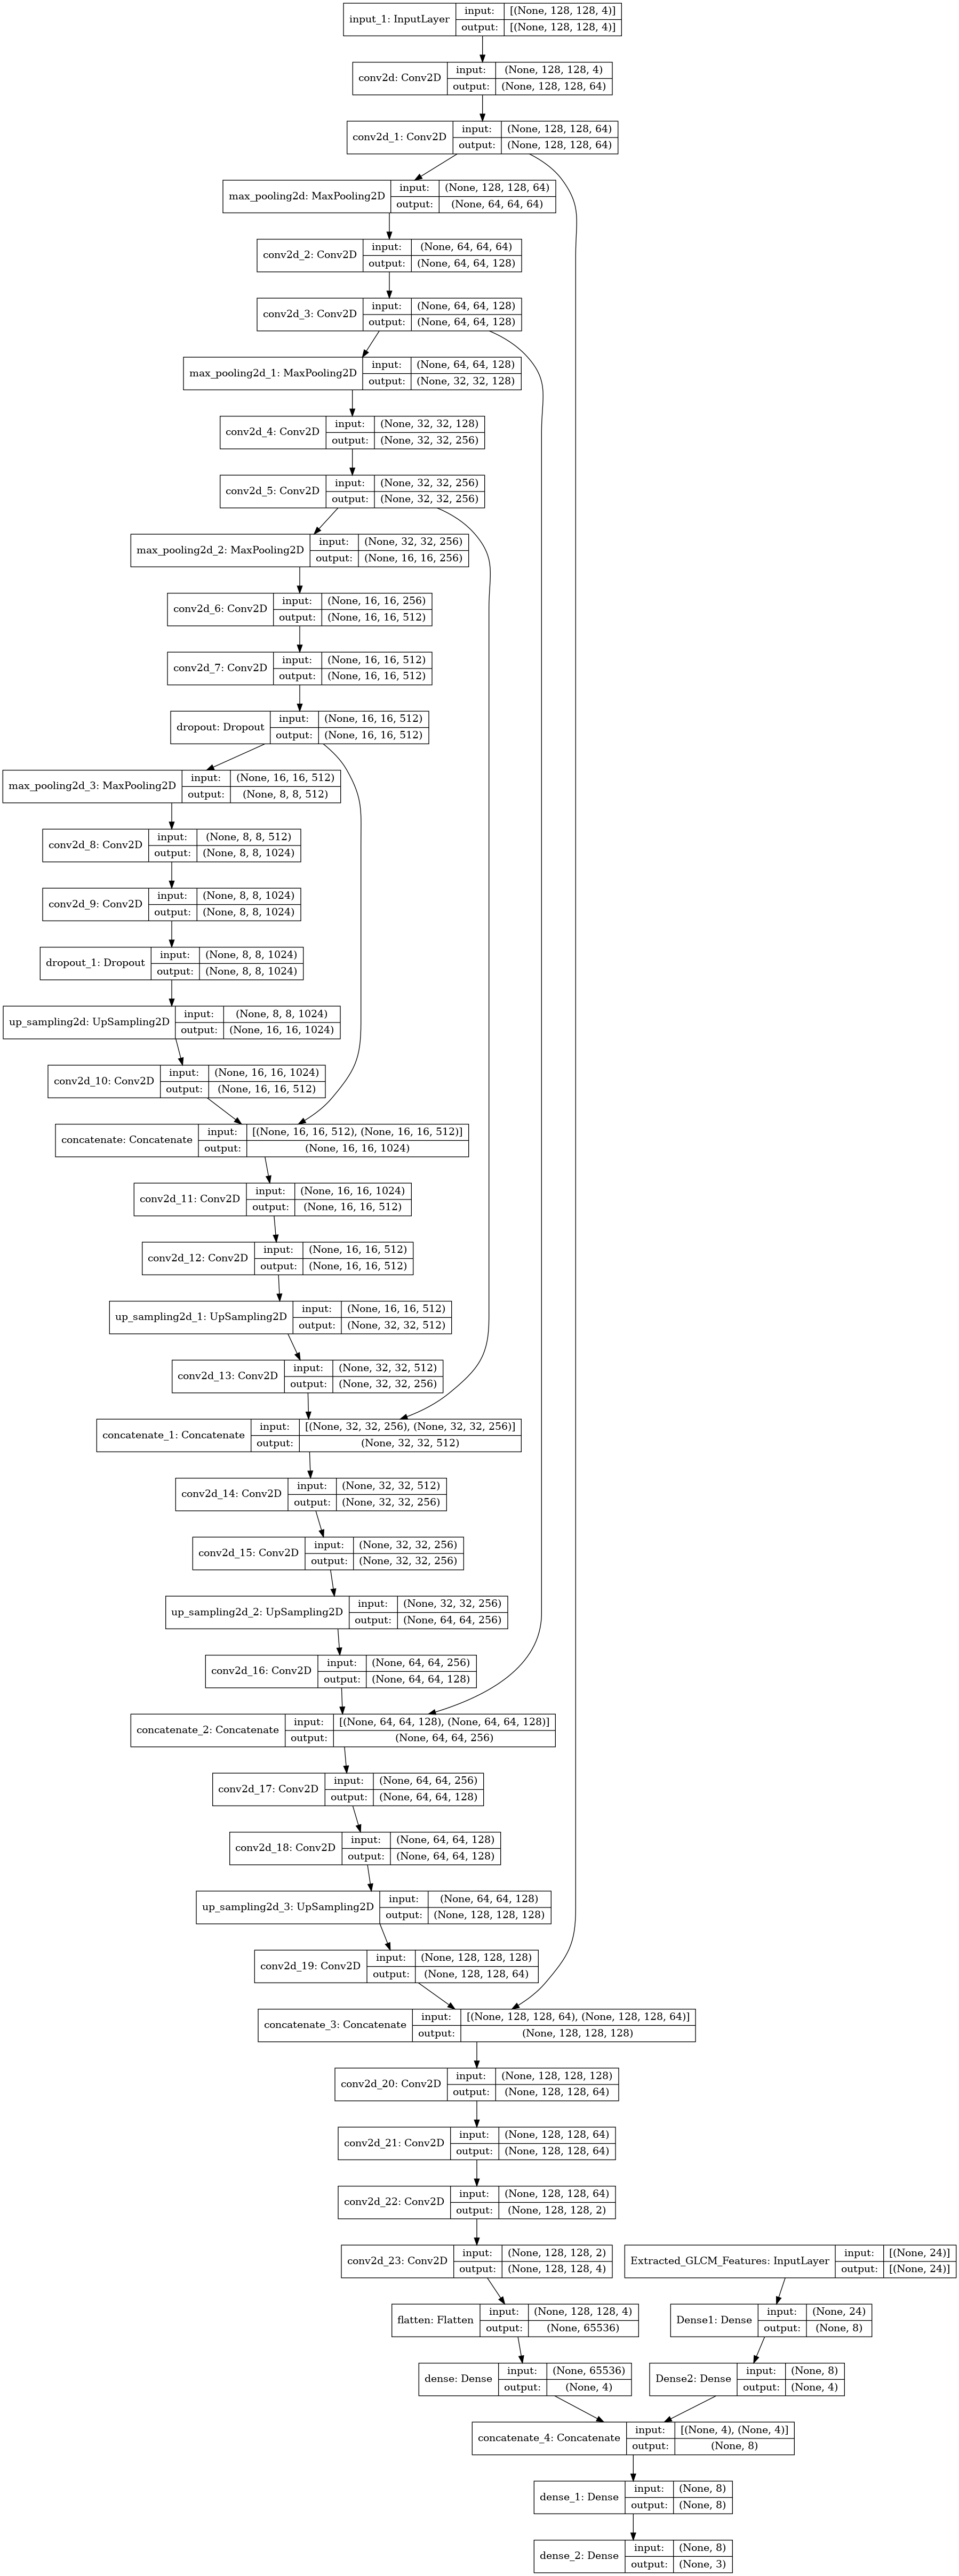

In [29]:
model_u.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])

plot_model(model_u, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

cb = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        mode='auto',
        min_delta=0.0002,
        cooldown=5,
        min_lr=10e-8,
        verbose=1,
    )
]

## Learning

In [31]:
train_dfu = train_df[:500]
train_images_normu=train_images_norm[:500]
train_labelsu=train_labels[:500]
val_dfu=val_df[:100]
val_images_normu=val_images_norm[:100]
val_labelsu=val_labels[:100]
test_dfu = test_df[:200]
test_images_normu=test_images_norm[:200]
test_labelsu=test_labels[:200]

In [32]:
dataset_inputs = tf.data.Dataset.from_tensor_slices((train_dfu, tf.expand_dims(train_images_normu, axis=-1)))
dataset_label = tf.data.Dataset.from_tensor_slices(train_labelsu)

dataset = tf.data.Dataset.zip((dataset_inputs, dataset_label)).batch(BATCH_SIZE).repeat()
STEP_SIZE_TRAIN= train_images_norm.shape[0]//BATCH_SIZE
# fit model
history_u = model_u.fit(dataset, 
                    validation_data=([val_dfu, tf.expand_dims(val_images_normu, axis=-1)], val_labelsu),
                    epochs = EPOCH_NUM, steps_per_epoch=32, callbacks=cb)

2021-12-05 18:08:59.402887: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 131072000 exceeds 10% of free system memory.
2021-12-05 18:08:59.503716: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 131072000 exceeds 10% of free system memory.


Epoch 1/200


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '
2021-12-05 18:09:00.761268: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-05 18:09:02.628970: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


32/32 [==============================] - ETA: 0s - loss: 10.9991 - categorical_accuracy: 0.3365

/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


32/32 [==============================] - 44s 890ms/step - loss: 10.9991 - categorical_accuracy: 0.3365 - val_loss: 1.5023 - val_categorical_accuracy: 0.3800
Epoch 2/200
32/32 [==============================] - 16s 505ms/step - loss: 1.2114 - categorical_accuracy: 0.3465 - val_loss: 1.1324 - val_categorical_accuracy: 0.3800
Epoch 3/200
32/32 [==============================] - 16s 506ms/step - loss: 1.1281 - categorical_accuracy: 0.3460 - val_loss: 1.1368 - val_categorical_accuracy: 0.3800
Epoch 4/200
32/32 [==============================] - 16s 505ms/step - loss: 1.1267 - categorical_accuracy: 0.3460 - val_loss: 1.1359 - val_categorical_accuracy: 0.3800
Epoch 5/200
32/32 [==============================] - 16s 505ms/step - loss: 1.1242 - categorical_accuracy: 0.3460 - val_loss: 1.1328 - val_categorical_accuracy: 0.3800
Epoch 6/200
32/32 [==============================] - 16s 505ms/step - loss: 1.1200 - categorical_accuracy: 0.3460 - val_loss: 1.1329 - val_categorical_accuracy: 0.3800
Epo

## Testing

In [33]:
test_inputs = tf.data.Dataset.from_tensor_slices((test_dfu, tf.expand_dims(test_images_normu, axis=-1)))
test_labels = tf.data.Dataset.from_tensor_slices(test_labelsu)

test_dataset = tf.data.Dataset.zip((test_inputs, test_labels)).batch(BATCH_SIZE).repeat()
STEP_SIZE_TEST= test_images_norm.shape[0]//BATCH_SIZE

score = model_u.evaluate(test_dataset, batch_size=BATCH_SIZE, steps=STEP_SIZE_TEST )
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

2021-12-05 19:03:30.514505: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 52428800 exceeds 10% of free system memory.
2021-12-05 19:03:30.539410: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 52428800 exceeds 10% of free system memory.


20/20 [==============================] - 4s 176ms/step - loss: 0.7282 - categorical_accuracy: 0.7600
Test loss: 0.7281889319419861 / Test accuracy: 0.7599999904632568


## Limitation des ressources (simple CNN)

In [34]:
def build_cnn():
    model = keras.Sequential([
        keras.Input(shape=(SIZE,SIZE,4), name='Original_Images'),
        keras.layers.Conv2D(input_shape=(140,140,1), filters=32, kernel_size=11, 
                            strides=1, activation='relu', name='Conv1'),
        keras.layers.Conv2D(input_shape=(130,130,32), filters=32, kernel_size=11, 
                            strides=1, activation='relu', name='Conv2'),
        keras.layers.MaxPool2D(pool_size=(5, 5), strides=2,padding='same'),
        keras.layers.Conv2D(input_shape=(58,58,32), filters=64, kernel_size=9, 
                            strides=1, activation='relu', name='Conv3'),
        keras.layers.MaxPool2D(pool_size=(5, 5), strides=2,padding='same'),
        keras.layers.Conv2D(input_shape=(23,23,64), filters=128, kernel_size=8, 
                            strides=1, activation='relu', name='Conv4'),
        keras.layers.Conv2D(input_shape=(16,16,128), filters=256, kernel_size=9, 
                            strides=1, activation='relu', name='Conv5'),
        keras.layers.Conv2D(input_shape=(8,8,256), filters=256, kernel_size=8, 
                            strides=1, activation='relu', name='Conv6'),    

        keras.layers.Flatten(),
        keras.layers.Dense(8, activation=tf.keras.activations.relu, name='Dense')
    ])
    print(model.summary())
    return model

In [35]:
def build_mlp():
    model = keras.Sequential([
        keras.Input(shape=24, name='Extracted_Traditional_Features'),
        keras.layers.Dense(8, activation=tf.keras.activations.relu, name='Dense1'),
        keras.layers.Dense(4, activation=tf.keras.activations.relu, name='Dense2')
    ])
    print(model.summary())
    return model

In [36]:
mlp = build_mlp()
cnn = build_cnn()

combinedInput = concatenate([mlp.output, cnn.output])

x = Dense(8, activation="relu")(combinedInput)
x = Dense(3, activation="softmax")(x)

model = Model(inputs=[mlp.input, cnn.input], outputs=x)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 8)                 200       
_________________________________________________________________
Dense2 (Dense)               (None, 4)                 36        
Total params: 236
Trainable params: 236
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 118, 118, 32)      15520     
_________________________________________________________________
Conv2 (Conv2D)               (None, 108, 108, 32)      123936    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 32)        0         
_____________________________

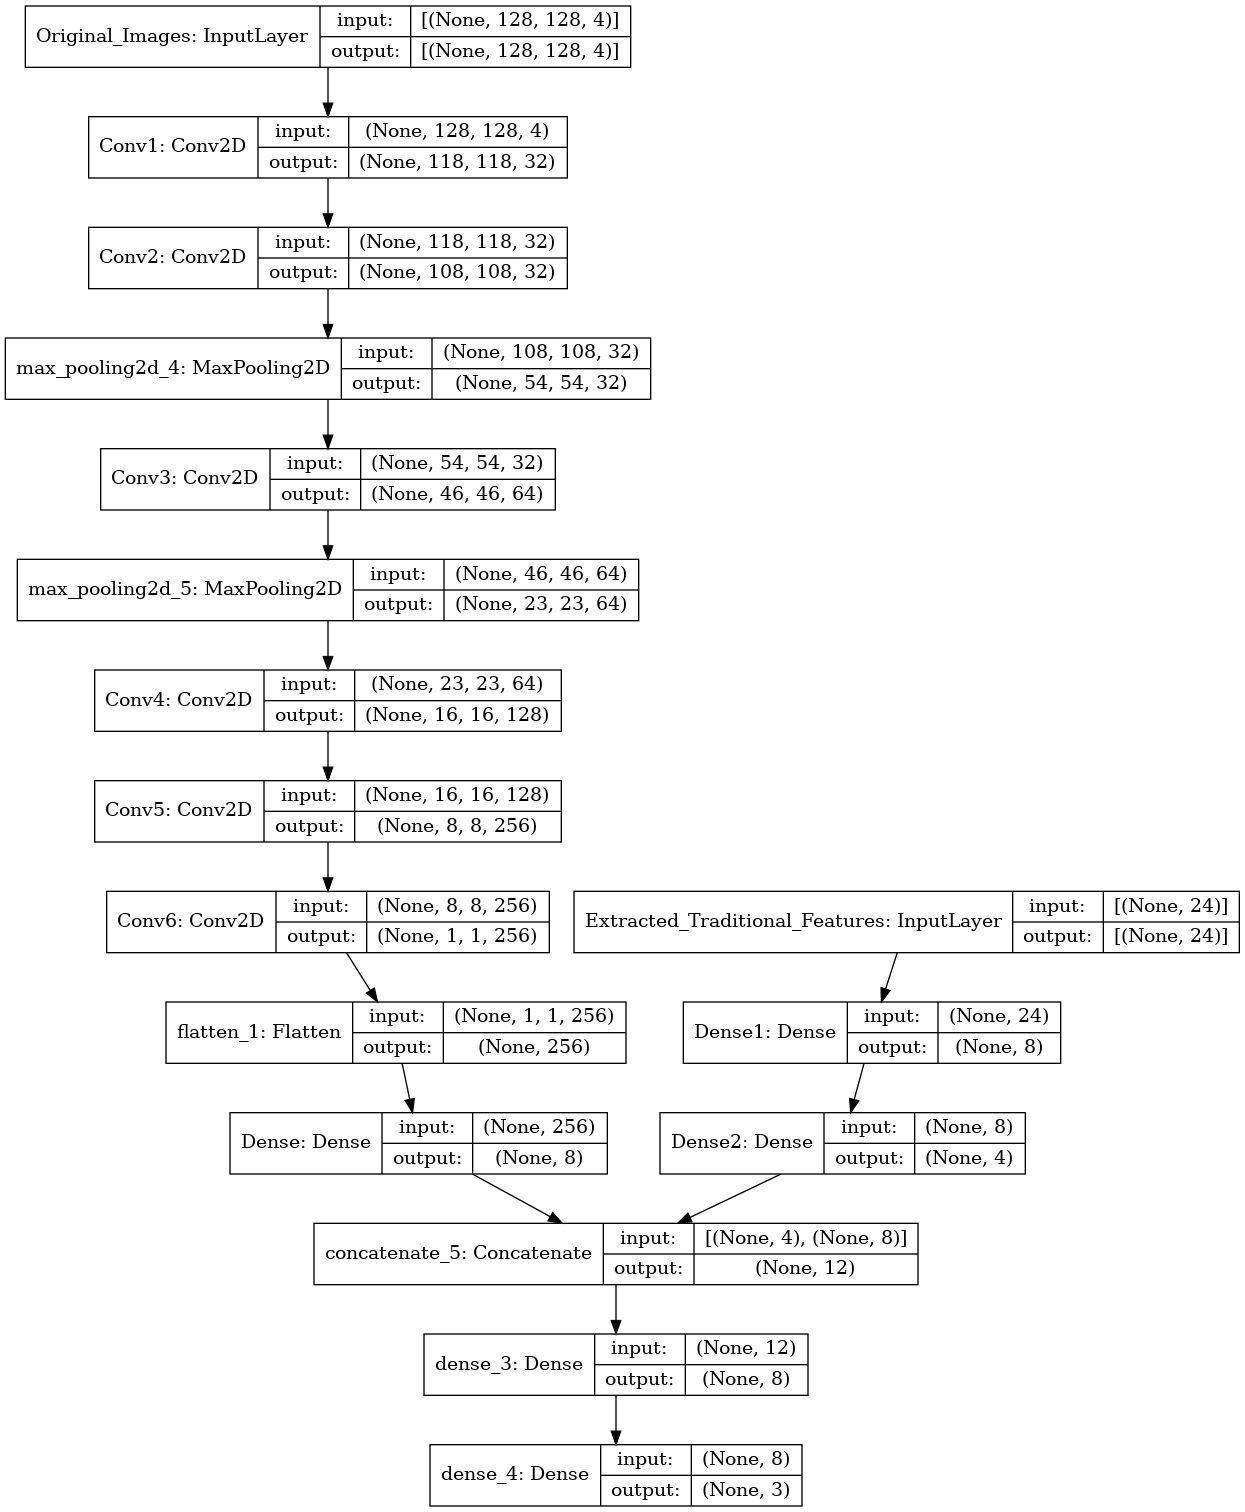

In [37]:
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [38]:
dataset_inputs = tf.data.Dataset.from_tensor_slices((train_df, tf.expand_dims(train_images_norm, axis=-1)))
dataset_label = tf.data.Dataset.from_tensor_slices(train_labels)

dataset = tf.data.Dataset.zip((dataset_inputs, dataset_label)).batch(BATCH_SIZE).repeat()
STEP_SIZE_TRAIN= train_images_norm.shape[0]//BATCH_SIZE
# fit model
history = model.fit(dataset, 
                    validation_data=([val_df, tf.expand_dims(val_images_norm, axis=-1)], val_labels),
                    epochs = EPOCH_NUM, steps_per_epoch=STEP_SIZE_TRAIN, callbacks=cb)

2021-12-05 19:03:57.553728: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 941096960 exceeds 10% of free system memory.


Epoch 1/200


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


55/56 [============================>.] - ETA: 0s - loss: 1.0978 - categorical_accuracy: 0.4895

/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


56/56 [==============================] - 6s 65ms/step - loss: 1.0978 - categorical_accuracy: 0.4927 - val_loss: 1.0973 - val_categorical_accuracy: 0.4858
Epoch 2/200
56/56 [==============================] - 3s 51ms/step - loss: 1.0963 - categorical_accuracy: 0.5428 - val_loss: 1.0963 - val_categorical_accuracy: 0.4511
Epoch 3/200
56/56 [==============================] - 3s 49ms/step - loss: 1.0953 - categorical_accuracy: 0.5493 - val_loss: 1.0954 - val_categorical_accuracy: 0.4779
Epoch 4/200
56/56 [==============================] - 3s 49ms/step - loss: 1.0944 - categorical_accuracy: 0.5448 - val_loss: 1.0948 - val_categorical_accuracy: 0.4937
Epoch 5/200
56/56 [==============================] - 3s 49ms/step - loss: 1.0936 - categorical_accuracy: 0.5414 - val_loss: 1.0940 - val_categorical_accuracy: 0.5032
Epoch 6/200
56/56 [==============================] - 3s 50ms/step - loss: 1.0928 - categorical_accuracy: 0.5406 - val_loss: 1.0933 - val_categorical_accuracy: 0.5032
Epoch 7/200
56/5

## Testing

In [39]:
test_inputs = tf.data.Dataset.from_tensor_slices((test_df, tf.expand_dims(test_images_norm, axis=-1)))
# test_labels = tf.data.Dataset.from_tensor_slices(test_labels)

test_dataset = tf.data.Dataset.zip((test_inputs, test_labels)).batch(BATCH_SIZE).repeat()
STEP_SIZE_TEST= test_images_norm.shape[0]//BATCH_SIZE

score = model.evaluate(test_dataset, batch_size=BATCH_SIZE, steps=STEP_SIZE_TEST )
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

20/20 [==============================] - 1s 28ms/step - loss: 1.3101 - categorical_accuracy: 0.0000e+00
Test loss: 1.3101098537445068 / Test accuracy: 0.0


In [40]:
import matplotlib.pyplot as plt
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])

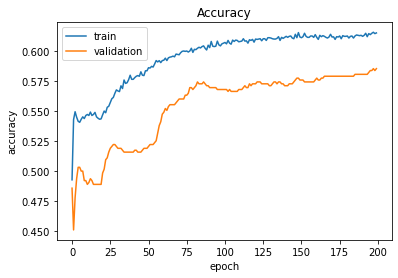

In [41]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

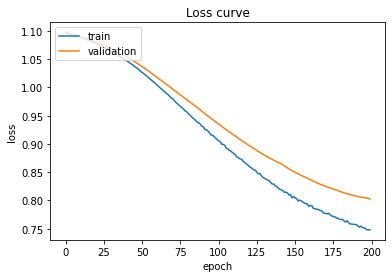

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()